In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ccf_polygons as cshapes
import ccf_plots as cplots
import abc_load

%matplotlib inline

sns.set_style('white')

In [3]:
from importlib import reload

## Load details (can skip)

In [3]:
from pathlib import Path
import json
# abc_root = Path("/data/allen-brain-cell-atlas/")
abc_root = Path("/data/abc_atlas/")
with open(abc_root/"releases/20230630/manifest.json") as file:
    manifest = json.load(file)
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']

FileNotFoundError: [Errno 2] No such file or directory: '/data/abc_atlas/releases/20230630/manifest.json'

In [ ]:

# cells_df = pd.read_csv(abc_root/metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path'], index_col=0)
cells_df = pd.read_csv("/data/abc_atlas/metadata/MERFISH-C57BL6J-638850/20230630/views/cell_metadata_with_cluster_annotation.csv",
# cells_df = pd.read_csv("/data/abc_atlas/metadata/MERFISH-C57BL6J-638850/20230630/cell_metadata.csv",
                       dtype={'cell_label':str}, index_col=0)
cells_df.shape

In [ ]:
cells_df.columns

Why is there missing position data across all sections? Additional attrition from slice coords to ccf is mostly at end sections, but this is distributed...

In [ ]:
cells_df['x'].isna().value_counts().sort_index()

In [ ]:
cells_df.loc[lambda df: df['x'].isna(), 'brain_section_label'].value_counts().sort_index()

In [ ]:
ccf_df = pd.read_csv("/data/abc_atlas/metadata/MERFISH-C57BL6J-638850-CCF/20230630/views/cell_metadata_with_parcellation_annotation.csv",
# ccf_df = pd.read_csv("/data/abc_atlas/metadata/MERFISH-C57BL6J-638850-CCF/20230630/reconstructed_coordinates.csv", 
                     dtype={'cell_label':str}, index_col=0)
ccf_df.shape

In [ ]:
ccf_df.columns

In [ ]:
metadata_ccf = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata_ccf['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
parcellation_annotation = pd.read_csv(abc_root/rpath, index_col=0)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
ccf_df = ccf_df.join(parcellation_annotation, on='parcellation_index')
ccf_df.columns

In [ ]:
rpath = metadata_ccf['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
ccf_colors = (pd.read_csv(abc_root/rpath, index_col=0)
              .join(parcellation_annotation)
              .set_index('parcellation_substructure'))

In [ ]:
adata_ref = ad.read_h5ad("/data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad",
                        backed='r')

adata = ad.read_h5ad("/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850-log2.h5ad", backed='r')
adata

In [ ]:
# QC'd cells or mismatched names?
len(adata_ref.obs_names.difference(adata.obs_names))

In [ ]:
adata = adata[adata.obs_names.intersection(adata_ref.obs_names)]
adata = adata.to_memory()
adata

In [ ]:
cells_df['y'] *= -1
cells_df.rename(columns={'x':'x_section','y':'y_section','z':'z_section'}, inplace=True)
ccf_df['y'] *= -1
ccf_df.rename(columns={'x':'x_reconstructed','y':'y_reconstructed','z':'z_reconstructed'}, inplace=True)

rename={
    'x_section':'cirro_x',
    'y_section':'cirro_y',
    'brain_section_label':'section',
    'parcellation_substructure':'CCF_acronym'
}

ccf_df.rename(columns=rename, inplace=True)
cells_df.rename(columns=rename, inplace=True)

In [ ]:
adata.obs = adata.obs.join(cells_df[cells_df.columns.difference(adata.obs.columns)])
adata.obs = adata.obs.join(ccf_df[ccf_df.columns.difference(adata.obs.columns)])

# define and view CCF polygons

In [4]:
adata = abc_load.load_adata(cirro_names=True, flip_y=True)

In [5]:
adata.obs['supertype'] = pd.Categorical(adata.obs['supertype'].str[5:])
adata.obs['subclass'] = pd.Categorical(adata.obs['subclass'].str[4:])

In [6]:
adata

AnnData object with n_obs × n_vars = 191578 × 550
    obs: 'brain_section_label', 'CCF_acronym', 'average_correlation_score', 'cirro_x', 'cirro_y', 'class', 'cluster', 'cluster_alias', 'neurotransmitter', 'parcellation_division', 'parcellation_index', 'parcellation_structure', 'section', 'subclass', 'supertype', 'x_ccf', 'x_reconstructed', 'y_ccf', 'y_reconstructed', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'

## calc polygons

In [7]:
ccf_polygons = cshapes.get_ccf_polygons(adata.obs)

In [8]:
ccf_polygons_th_zi = ccf_polygons[ccf_polygons.index.isin(cshapes.CCF_TH_NAMES, level="name")]

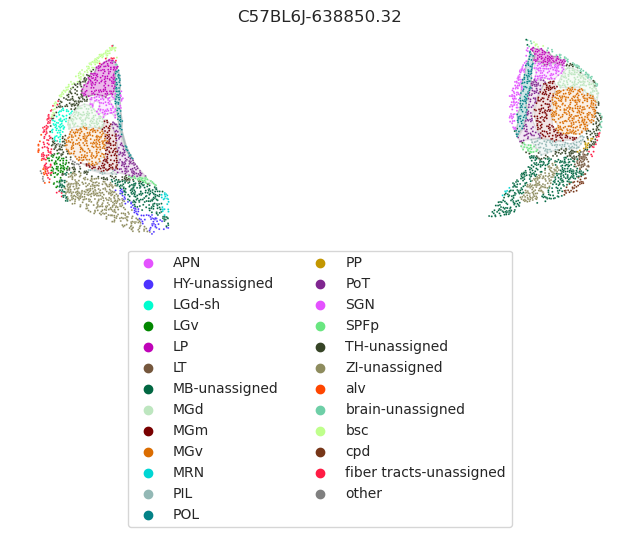

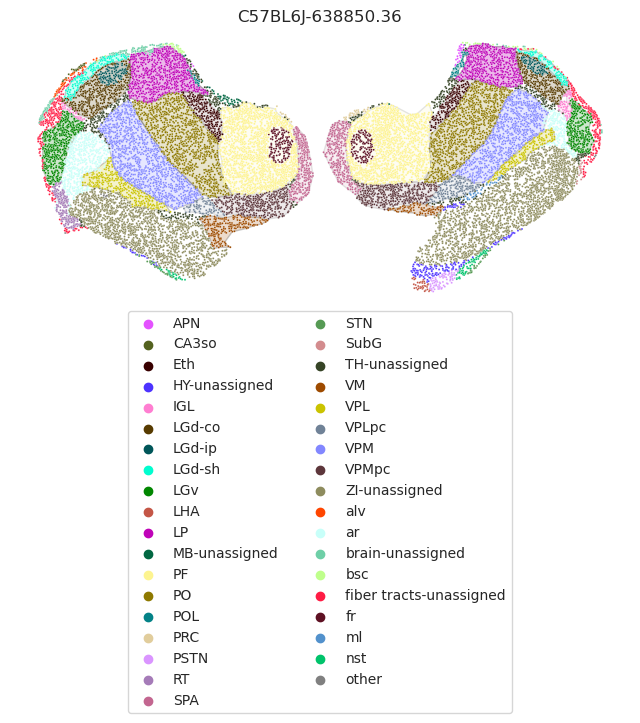

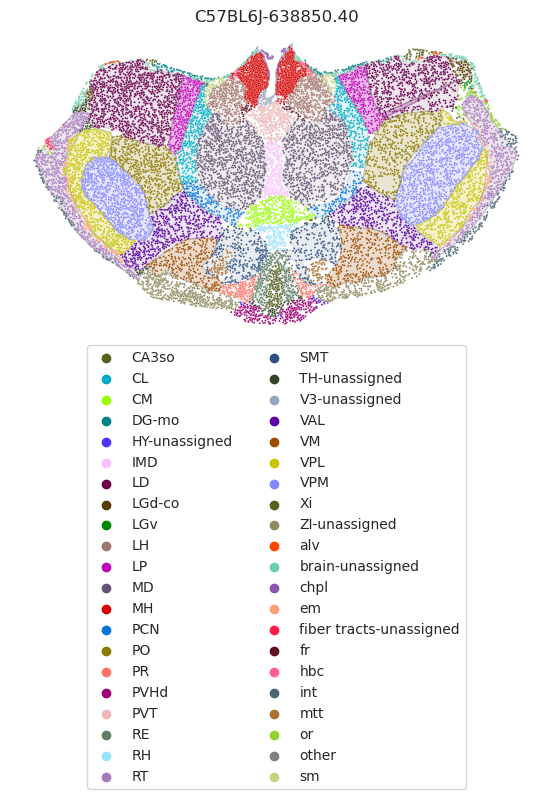

In [9]:
# sections = ["1199651024", "1199651036", "1199651048"]
sections = ["C57BL6J-638850.32", "C57BL6J-638850.36", "C57BL6J-638850.40"]
cplots.plot_ccf_overlay(adata.obs, ccf_polygons_th_zi, sections=sections)

## view thalamus subset with subclass labels

In [10]:
nonneuronal_classes = ['30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular', '34 Immune']
adata_neuronal = adata[~adata.obs["class"].isin(nonneuronal_classes)].copy()
# cluster_id as string to simplify querying
adata_neuronal.obs['cluster_id'] = pd.Categorical(adata_neuronal.obs['cluster'].apply(
    lambda x: x.split(' ')[0]))

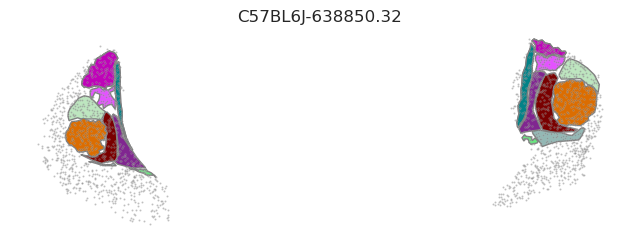

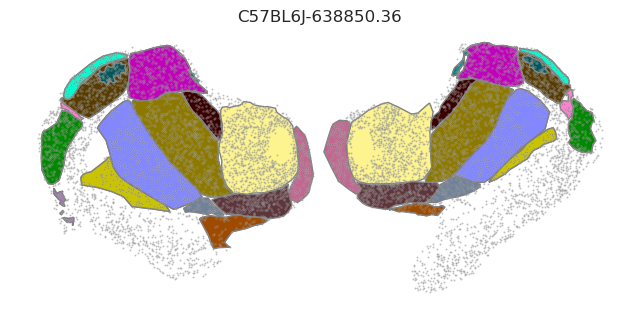

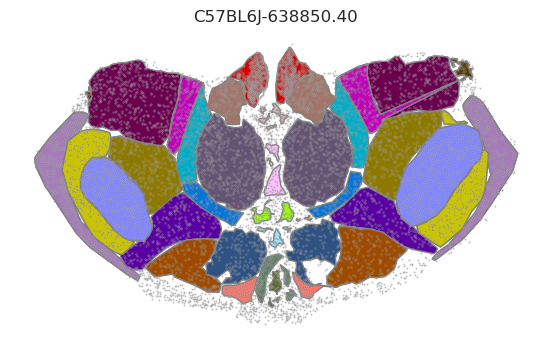

In [11]:
# may need to tweak clustering params on fine 
cplots.plot_ccf_overlay(adata.obs.iloc[[],:]#no foreground cells
                       , ccf_polygons_th_zi, sections=sections, highlight='all', 
                           # x_field='x_section', y_field='y_section',
                 bg_cells=adata_neuronal.obs, bg_shapes=False, min_group_count=0, legend=False)

In [12]:
subclasses = adata_neuronal.obs['subclass'].value_counts().loc[lambda x: x>300]
subclasses

subclass
TH Prkcd Grin2c Glut                  39270
RT-ZI Gnb3 Gaba                        7772
MH Tac2 Glut                           4622
ZI Pax6 Gaba                           4432
PVT-PT Ntrk1 Glut                      4132
PF Fzd5 Glut                           4008
RE-Xi Nox4 Glut                        3831
CM-IAD-CL-PCN Sema5b Glut              3497
SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut     2349
AV Col27a1 Glut                        1714
LGv-ZI Otx2 Gaba                       1336
LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba       1289
AD Serpinb7 Glut                       1182
LH Pou4f1 Sox1 Glut                    1049
MG-POL-SGN Nts Glut                     782
SNr Six3 Gaba                           343
PRC-PAG Tcf7l2 Irx2 Glut                308
Name: count, dtype: int64

In [13]:
len(subclasses)

17

In [14]:
adata_neuronal.obs.loc[lambda df: df['subclass'].isin(subclasses.index), 'neurotransmitter'].value_counts().loc[lambda x: x>0]

neurotransmitter
Glut    64520
GABA    15172
Chol     2224
Name: count, dtype: int64

In [15]:
adata_neuronal.obs.loc[lambda df: df['subclass'].isin(subclasses.index), 'class'].value_counts().loc[lambda x: x>0]

class
18 TH Glut       58416
12 HY GABA       13540
17 MH-LH Glut     5671
19 MB Glut        2657
20 MB GABA        1632
Name: count, dtype: int64

In [16]:
adata_neuronal.obs.loc[lambda df: df['subclass'].isin(subclasses.index), 'supertype'].unique().shape[0]

89

In [17]:
adata_neuronal.obs.loc[lambda df: df['subclass'].isin(subclasses.index), 'cluster'].unique().shape[0]

397

In [18]:
from colorcet import glasbey
point_palette = dict(zip(subclasses.index, sns.color_palette(glasbey, n_colors=len(subclasses.index))))

from matplotlib.colors import rgb2hex
{x.replace(' ', '_'): rgb2hex(point_palette[x]) for x in point_palette.keys()}

{'TH_Prkcd_Grin2c_Glut': '#d60000',
 'RT-ZI_Gnb3_Gaba': '#8c3bff',
 'MH_Tac2_Glut': '#018700',
 'ZI_Pax6_Gaba': '#00acc6',
 'PVT-PT_Ntrk1_Glut': '#97ff00',
 'PF_Fzd5_Glut': '#ff7ed1',
 'RE-Xi_Nox4_Glut': '#6b004f',
 'CM-IAD-CL-PCN_Sema5b_Glut': '#ffa52f',
 'SPA-SPFm-SPFp-POL-PIL-PoT_Sp9_Glut': '#573b00',
 'AV_Col27a1_Glut': '#005659',
 'LGv-ZI_Otx2_Gaba': '#0000dd',
 'LGv-SPFp-SPFm_Nkx2-2_Tcf7l2_Gaba': '#00fdcf',
 'AD_Serpinb7_Glut': '#a17569',
 'LH_Pou4f1_Sox1_Glut': '#bcb6ff',
 'MG-POL-SGN_Nts_Glut': '#95b577',
 'SNr_Six3_Gaba': '#bf03b8',
 'PRC-PAG_Tcf7l2_Irx2_Glut': '#645474'}

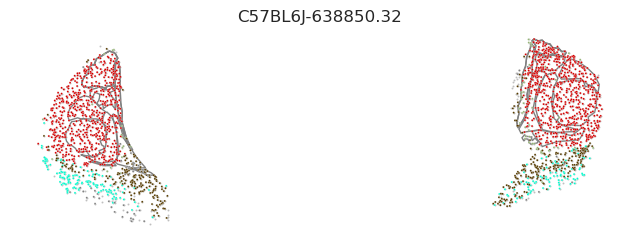

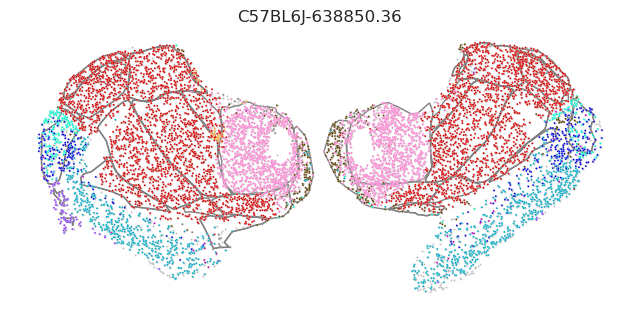

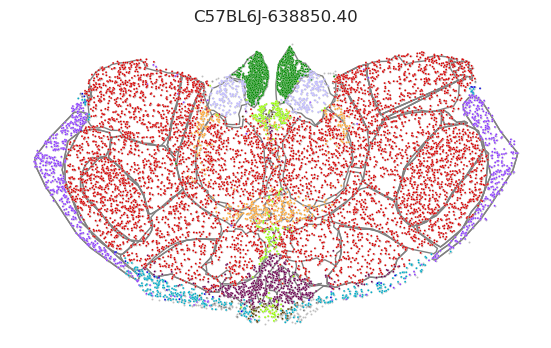

In [19]:
obs = adata_neuronal.obs.loc[lambda df: df['subclass'].isin(subclasses.index)]
cplots.plot_ccf_overlay(obs, ccf_polygons_th_zi, bg_cells=adata_neuronal.obs, point_hue='subclass', sections=sections,
                 shape_palette='dark_outline', point_palette=point_palette, legend=False, highlight='all',
                           # x_field='x_section', y_field='y_section',
                 min_group_count=30)

# Investigate prong 1 cluster-nucleus groups

In [23]:
nuclei_df = pd.read_csv("../resources/Prong 1 Vitessce links by nucleus.csv", index_col=0)

def get_obs_from_annotated_clusters(name, adata, nuclei_df):
    clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
    obs = adata.obs.loc[lambda df: df['cluster_id'].isin(clusters)]
    return obs

## VM

In [54]:
obs = adata_neuronal.obs.query("supertype=='TH Prkcd Grin2c Glut_13'")
obs['cluster'].value_counts().loc[lambda x: x>5]

cluster
2683 TH Prkcd Grin2c Glut_13    1612
2687 TH Prkcd Grin2c Glut_13    1209
2686 TH Prkcd Grin2c Glut_13     398
2685 TH Prkcd Grin2c Glut_13      59
2684 TH Prkcd Grin2c Glut_13      42
Name: count, dtype: int64

In [37]:
clusters_VM = ['2683 TH Prkcd Grin2c Glut_13', '2687 TH Prkcd Grin2c Glut_13']

C57BL6J-638850.33


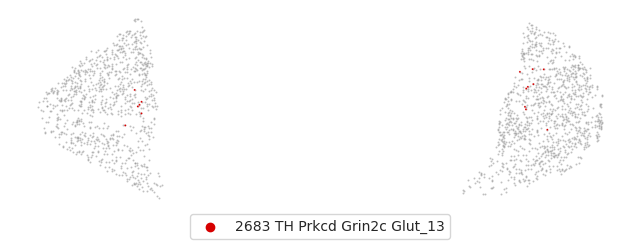

C57BL6J-638850.36


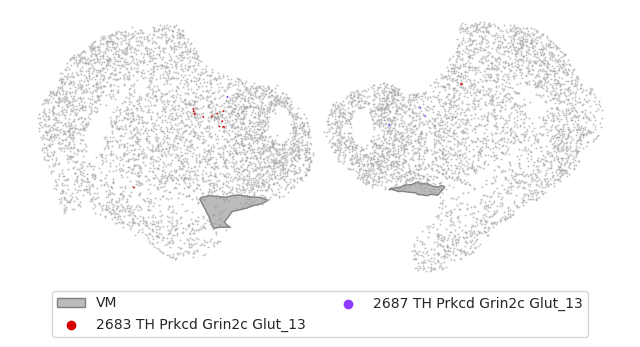

C57BL6J-638850.37


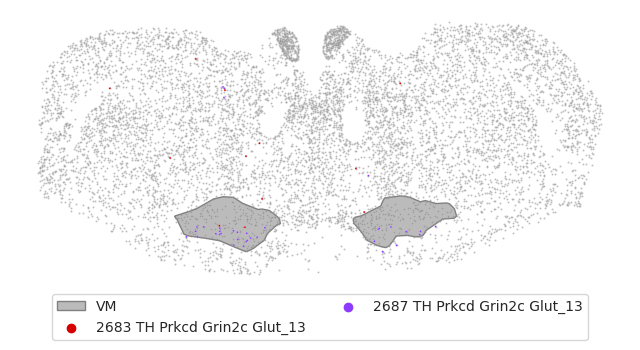

C57BL6J-638850.38


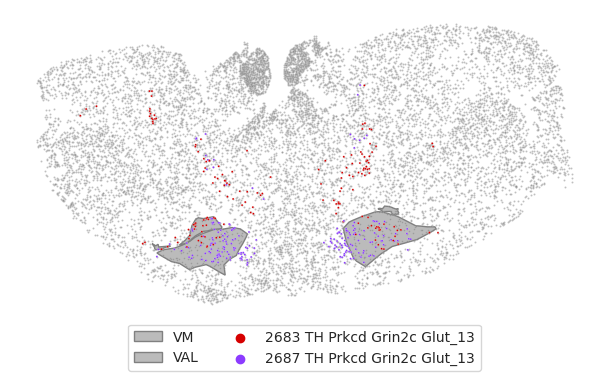

C57BL6J-638850.39


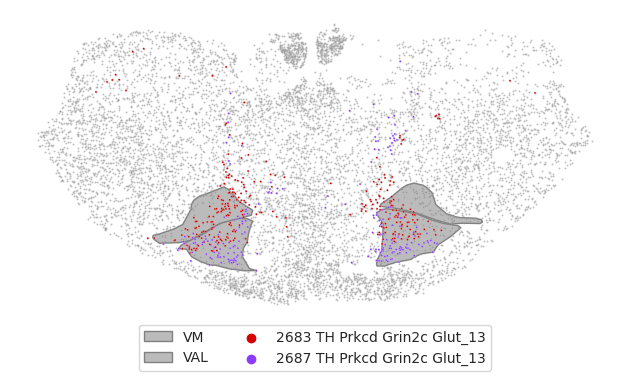

C57BL6J-638850.40


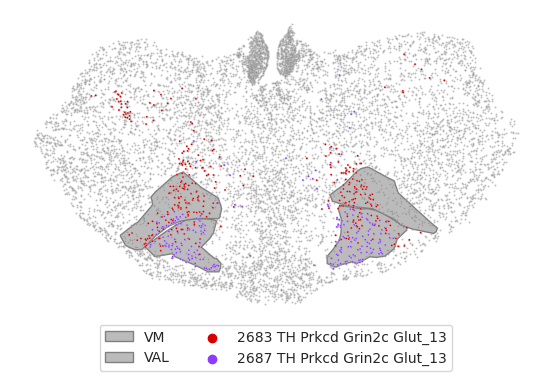

C57BL6J-638850.42


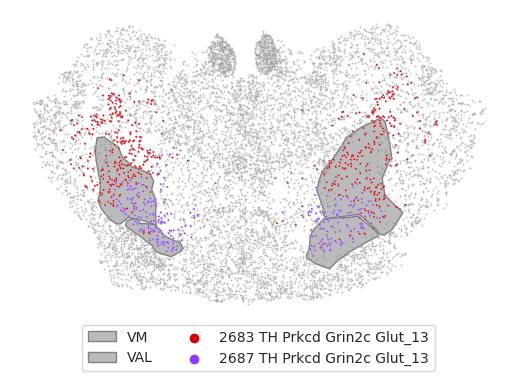

C57BL6J-638850.43


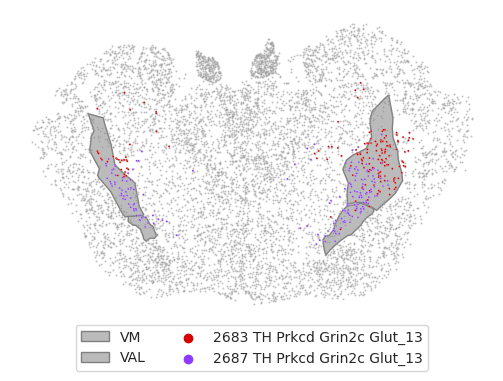

C57BL6J-638850.44


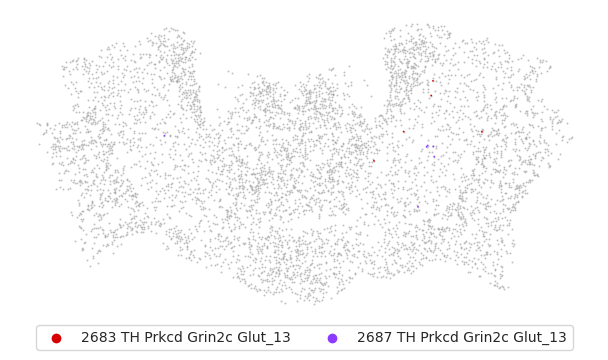

In [58]:
obs_VM = adata_neuronal.obs.query("cluster=='2683 TH Prkcd Grin2c Glut_13' | cluster=='2687 TH Prkcd Grin2c Glut_13'")
cplots.plot_nucleus_cluster_comparison_slices(obs_VM, ccf_polygons_th_zi, nuclei=['VM', 'VAL'], legend='both', bg_cells=adata_neuronal.obs, bg_shapes=False, shape_palette='greyscale')

In [53]:
# remove 1140? annotated as VPMpc
clusters = ['1138', '1141', '1142']
obs = adata.obs.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=['VM'], legend='cells', bg_cells=adata_neuronal.obs, bg_shapes=False, shape_palette='greyscale')

### diff exp

In [ ]:
import scanpy as sc

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'cluster_id', groups=['1142'], reference='1138', method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [ ]:
section='C57BL6J-638850.40'
gene = "Calb1"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = "Necab1"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = "Spon1"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = "Cbln1"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = 'Tmie'
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = 'Galnt18'
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'supertype', groups=['TH Prkcd Grin2c Glut_13'], method='wilcoxon', tie_correct=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'cluster_id', groups=['1142'], method='wilcoxon', tie_correct=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [ ]:
# ISH diff ex search
# https://mouse.brain-map.org/gene/show/87708

gene = "Galnt18"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = "Stxbp6"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

In [ ]:
gene = "Spon1"
nuclei=['VM', 'VAL']
highlight_nuclei=['VM']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, 
                    bg_shapes=False, highlight=highlight_nuclei,
                    cmap='Blues', show_outline=True);

### outlining VM / composition

In [35]:
import geopandas as gp
neuron_points = gp.GeoSeries.from_xy(*adata_neuronal.obs[['cirro_x','cirro_y']].values.T, index=adata_neuronal.obs_names)

In [ ]:
import hdbscan
section='C57BL6J-638850.40'
adata_vm = adata_neuronal[adata_neuronal.obs.query(f"section=='{section}' & cluster_id=='1142'").index].copy()
df = adata_vm.obs
X = df[['cirro_x','cirro_y']].values
df['spatial_cluster'] = hdbscan.HDBSCAN(min_samples=5).fit_predict(X)
core_clusters = df['spatial_cluster'].value_counts().index[:2]
df['spatial_group'] = df['spatial_cluster'].apply(lambda x: 'core' if x in core_clusters else 'other')

In [ ]:
sns.scatterplot(data=df,  x='cirro_x', y='cirro_y', hue='spatial_cluster', s=4,  legend=True, palette='tab10')

In [ ]:
nucleus = cshapes.get_polygon_from_obs(df.query("spatial_group=='core'"))
subset = neuron_points.geometry.intersects(nucleus)
adata_neuronal.obs['in_nucleus'] = subset.values
adata_nucleus = adata_neuronal[subset]

In [ ]:
adata_neuronal.obs.query(f"section=='{section}' & supertype=='TH Prkcd Grin2c Glut_13'").groupby(['cluster'])['in_nucleus'].apply(lambda x: x.value_counts())

In [ ]:
# need to include VAL types ??

In [ ]:
sc.tl.rank_genes_groups(adata_vm, 'spatial_group', groups=['core'], reference='other', method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_vm, groups=['core'], n_genes=20)

## anterior

In [65]:
obs = adata_neuronal.obs.query("supertype=='AD Serpinb7 Glut_1'")
obs['cluster'].value_counts().loc[lambda x: x>5]

cluster
2614 AD Serpinb7 Glut_1    713
2613 AD Serpinb7 Glut_1    469
Name: count, dtype: int64

In [66]:
obs = adata_neuronal.obs.query("supertype=='AV Col27a1 Glut_1'")
obs['cluster'].value_counts().loc[lambda x: x>5]

cluster
2616 AV Col27a1 Glut_1    893
2615 AV Col27a1 Glut_1    821
Name: count, dtype: int64

In [67]:
obs = adata_neuronal.obs.query("supertype=='TH Prkcd Grin2c Glut_9'")
obs['cluster'].value_counts().loc[lambda x: x>5]

cluster
2674 TH Prkcd Grin2c Glut_9    673
2675 TH Prkcd Grin2c Glut_9    346
2676 TH Prkcd Grin2c Glut_9    329
Name: count, dtype: int64

In [68]:
clusters = [str(x) for x in list(range(2613, 2616+1)) + list(range(2674, 2676+1))]
obs = adata.obs.loc[lambda df: df['cluster'].str[:4].isin(clusters)]

C57BL6J-638850.42


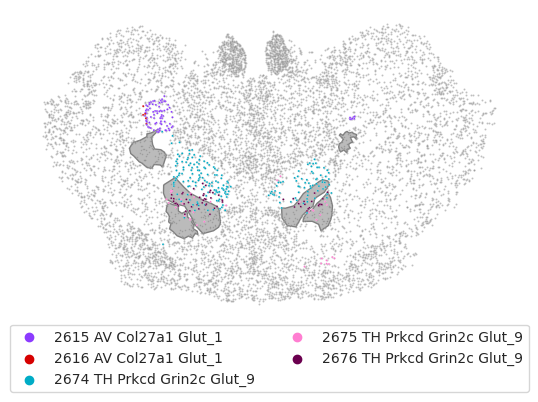

C57BL6J-638850.43


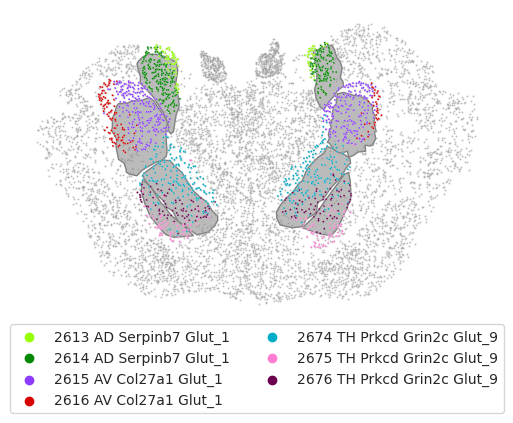

C57BL6J-638850.44


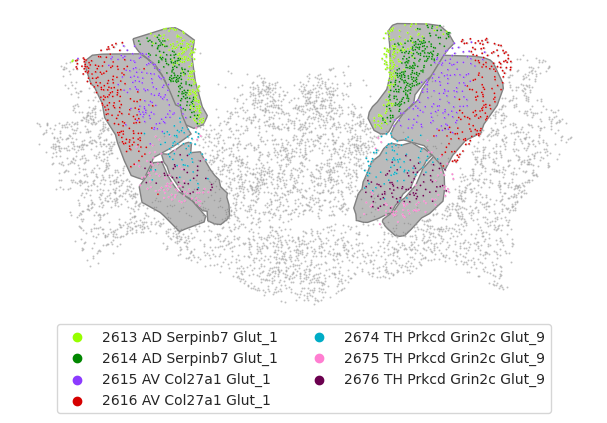

C57BL6J-638850.45


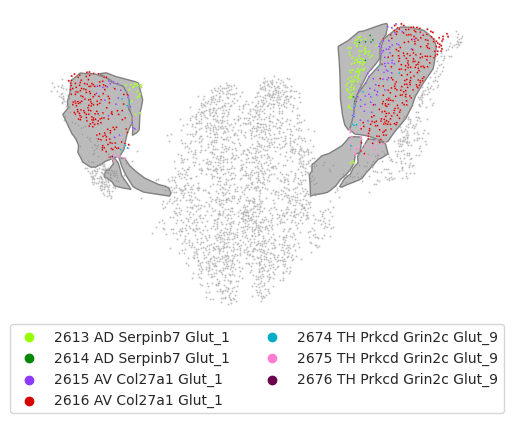

In [71]:
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, 
                                              nuclei=['AD','AMd','AMv','AV'], 
                                              legend='cells', 
                                              bg_cells=adata_neuronal.obs, 
                                              bg_shapes=False, 
                                              shape_palette='greyscale')

In [ ]:
nuclei=['AD', 'AV', 'AMd', 'AMv']
section = 'C57BL6J-638850.44'
# cplots.plot_ccf_section(ccf_polygons_th_zi, section, highlight=nuclei, )
cplots.plot_ccf_overlay(adata.obs.loc[[],:], ccf_polygons_th_zi, sections=[section], highlight=nuclei, legend='both', bg_cells=adata_neuronal.obs, bg_shapes=True, min_group_count=0)

In [ ]:
# cplots.plot_nucleus_cluster_comparison_slices('AD', adata, nuclei_df, ccf_polygons_th_zi)
obs = get_obs_from_annotated_clusters('AD', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei='AD')

### diff exp

#### AV

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'subclass', groups=['AV Col27a1 Glut'], method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

##### Col27a1

KeyError: 'spatial_cirro'

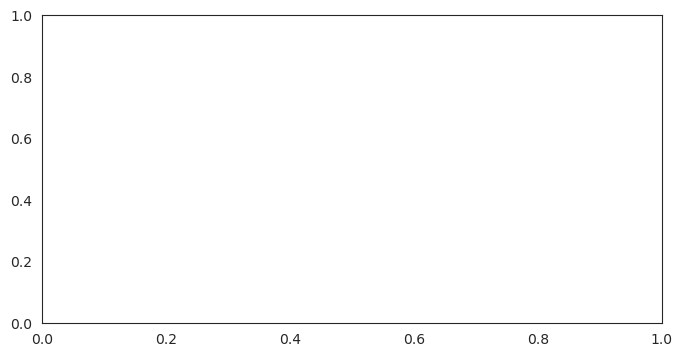

In [60]:
section = 'C57BL6J-638850.44'

gene = "Col27a1"
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AD', 'AV']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=ant_nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True, highlight=highlight_nuclei);

##### Sorcs3
Mathew's plots in brain1 suggested high expression exclusively in the '1097 AV Col27a1 Glut cluster' in the AV

That does not appear to be the case in brain3...

In [ ]:

# Mathew's plots in brain1 suggested high expression exclusively in the '1097 AV Col27a1 Glut cluster' in the AV
# That does not appear to be the case in brain3...
gene = "Sorcs3"
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AV']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=ant_nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True, highlight=highlight_nuclei);

#### AD

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'subclass', groups=['AD Serpinb7 Glut'], method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [ ]:

gene = "Syndig1l"
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AD']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=ant_nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True, highlight=highlight_nuclei);

#### AM

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'supertype', groups=['TH Prkcd Grin2c Glut_9'], method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [ ]:

gene = "Cbln1"
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AMd', 'AMv']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=ant_nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True, highlight=highlight_nuclei);

In [ ]:
adata_neuronal.obs['anterior_type'] = (adata_neuronal.obs['supertype'].str.contains('Glut_9') |
                                       adata_neuronal.obs['supertype'].str.contains('AD') |
                                       adata_neuronal.obs['supertype'].str.contains('AV')).astype(str)

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'anterior_type', method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

In [13]:

gene = "C1ql3"
nuclei=['AD', 'AV', 'AMd', 'AMv']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True);

NameError: name 'adata_neuronal' is not defined

In [ ]:

gene = "Shox2"
nuclei=['AD', 'AV', 'AMd', 'AMv']
cplots.plot_expression_ccf(adata_neuronal, section, gene, ccf_polygons, nuclei=nuclei, bg_shapes=False, 
                    cmap='Blues', show_outline=True);

## MD

In [ ]:
cluster = "1133 TH Prkcd Grin2c Glut_10"
obs = adata.obs.loc[lambda df: df['cluster']==cluster]
nuclei = ['MD']
palette = {cluster: "#bcbd22"}
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=nuclei, legend='cells', bg_cells=adata_neuronal.obs, bg_shapes=False, 
                                       shape_palette='dark_outline', point_palette=palette, s=5)

In [ ]:
cluster = "1130 TH Prkcd Grin2c Glut_1"
obs = adata.obs.loc[lambda df: df['cluster']==cluster]
nuclei = ['MD']
palette = {cluster: "#bcbd22"}
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=nuclei, legend='cells', bg_cells=adata_neuronal.obs, bg_shapes=False, 
                                       shape_palette='dark_outline', point_palette=palette, s=5)

In [ ]:
# TODO: should probably remove 1132 from annotation
obs = get_obs_from_annotated_clusters('MD', adata_neuronal, nuclei_df)

cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=nuclei, legend='cells', bg_cells=adata_neuronal.obs, bg_shapes=False, 
                                       shape_palette='dark_outline', s=5)

### diff exp

In [ ]:
sc.tl.rank_genes_groups(adata_neuronal, 'cluster_id', groups=['1133'], method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_neuronal, n_genes=20)

## other

In [ ]:
obs = get_obs_from_annotated_clusters('PT', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei='PT', legend='cells', bg_cells=adata_neuronal.obs, bg_shapes=False, 
                                       shape_palette='dark_outline', s=5)

In [ ]:
obs = adata_neuronal.obs.query("supertype.str.contains('PVT-PT')", engine='python')
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=['PT','PVT'], bg_cells=adata_neuronal.obs, bg_shapes=False, legend='both')

In [ ]:
obs = get_obs_from_annotated_clusters('PVT', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=['PT','PVT'], bg_cells=adata_neuronal.obs, bg_shapes=False, legend='both')

In [ ]:
obs = get_obs_from_annotated_clusters('LGd', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei=['LGd-co', 'LGd-ip', 'LGd-sh'], bg_cells=adata_neuronal.obs, bg_shapes=False)

In [ ]:
obs = get_obs_from_annotated_clusters('SMT', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei='SMT', bg_cells=adata_neuronal.obs, bg_shapes=False)

In [ ]:
obs = get_obs_from_annotated_clusters('LD', adata_neuronal, nuclei_df)
cplots.plot_nucleus_cluster_comparison_slices(obs, ccf_polygons_th_zi, nuclei='LD', bg_cells=adata_neuronal.obs, bg_shapes=False)